In [7]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft2, irfft2
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

y, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None

with h5py.File(h5_files[1], "r") as data:
    y = data["y"][100:]
    Hs = data.attrs["Hs"]
    Tp = data.attrs["Tp"]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

index = 0

In [15]:
eta_hat = y[:121, 0].copy()
phi_hat = y[:121, 1]

X, Y = np.meshgrid(x, x)
mask = ((X-1500)**2+(Y-1500)**2) <= 200**2
mask_2 = ((X-1500)**2+(Y-1500)**2) < 1500**2

mask_i_left = []
mask_i_right = []
mask_i = []
mask_j = []

I, J = np.meshgrid(np.arange(0, 2*modes), np.arange(0, 2*modes))
for i in range(2*modes):
    for j in range(2*modes):
        if not mask[i, j]:
            continue

        for k in range(modes):
            if not mask[modes+k, j]:
                mask_i.append(i)
                mask_j.append(j)
                mask_i_left.append(modes+k)
                mask_i_right.append(modes-k-1)
                break

mask_2_i = []
mask_2_j = []
mask_2_i_map = []
mask_2_j_map = []
for j in range(2*modes):
    for i in range(modes):
        if mask_2[i, j]: continue
        for k in range(modes):
            if mask_2[i+k, j]:
                mask_2_i.append(i)
                mask_2_j.append(j)
                mask_2_i_map.append(i+k)
                mask_2_j_map.append(j)
                break

for j in range(2*modes):
    for i in range(modes, 2*modes):
        if mask_2[i, j]: continue
        for k in range(modes):
            if mask_2[i-k, j]:
                mask_2_i.append(i)
                mask_2_j.append(j)
                mask_2_i_map.append(i-k)
                mask_2_j_map.append(j)
                break

mask_i = np.array(mask_i)
mask_j = np.array(mask_j)
mask_i_left = np.array(mask_i_left)
mask_i_right = np.array(mask_i_right)

mask_2_i = np.array(mask_2_i)
mask_2_j = np.array(mask_2_j)
mask_2_i_map = np.array(mask_2_i_map)
mask_2_j_map = np.array(mask_2_j_map)

eta = irfft2(eta_hat).astype(np.float32)
eta[:, mask_i, mask_j] = (eta[:, mask_i_left, mask_j] + eta[:, mask_i_right, mask_j])*0.5
eta[:, mask_2_i, mask_2_j] = eta[:, mask_2_i_map, mask_2_j_map]
eta_hat = rfft2(eta).astype(np.complex64)

indexes = np.concatenate((np.arange(0, modes+1), np.arange(2, modes+1)[::-1]))
mask_vert = indexes < 202+1
mask_hor = np.arange(0, modes+1) < 202+1
eta_hat[:, ~mask_vert, :] = 0
eta_hat[:, :, ~mask_hor] = 0

C:\Users\Vegard\AppData\Local\Temp\ipykernel_22972\4273021419.py:22: RuntimeWarning: divide by zero encountered in divide
  L2 = 1.0 / K - 9.81


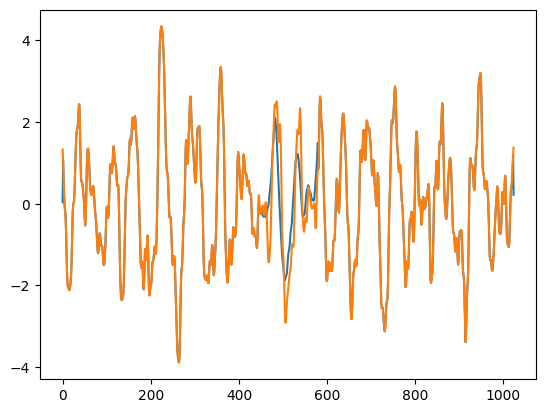

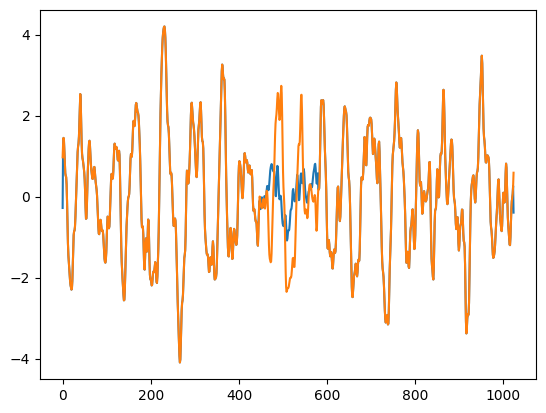

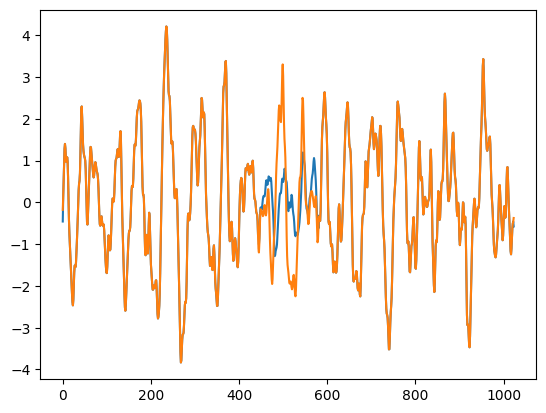

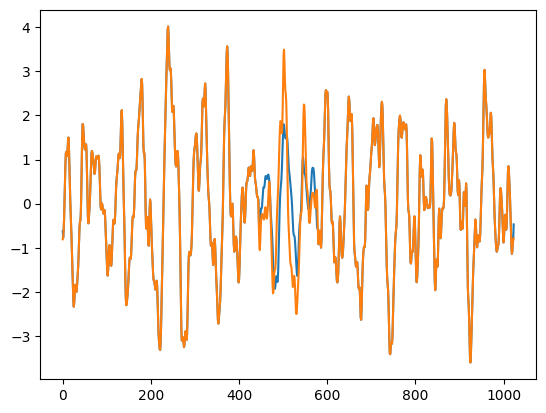

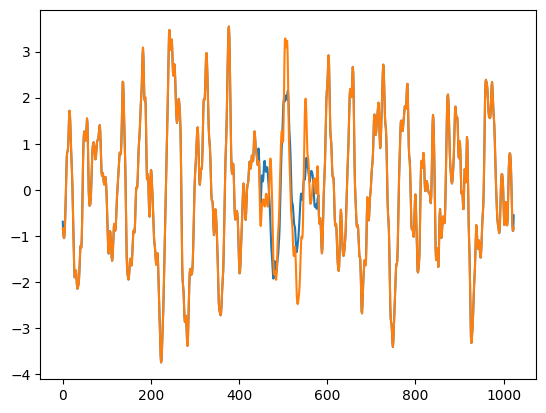

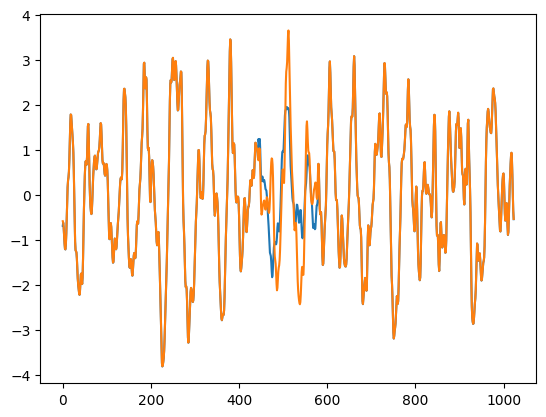

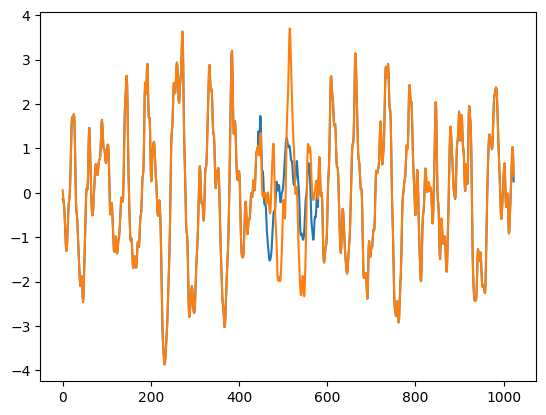

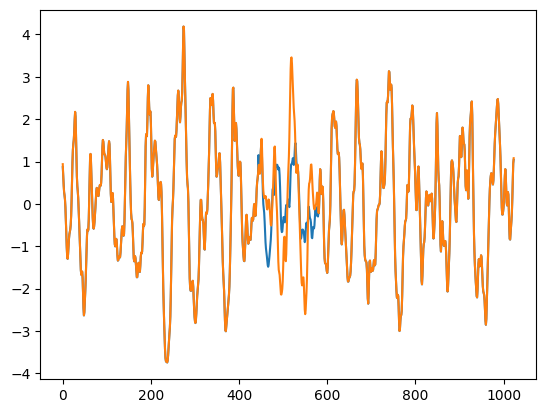

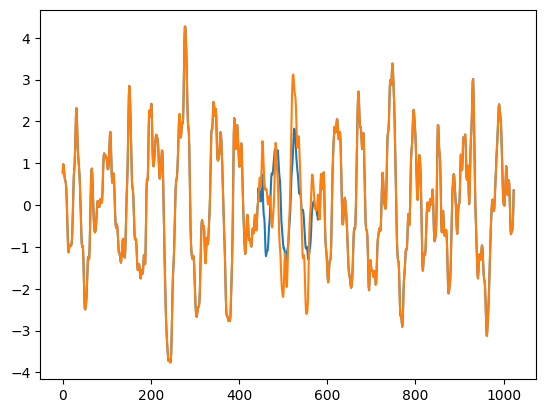

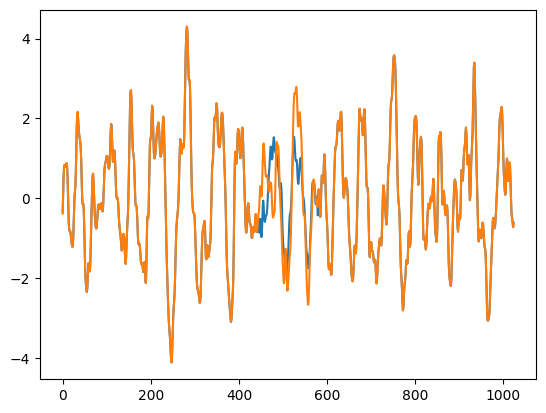

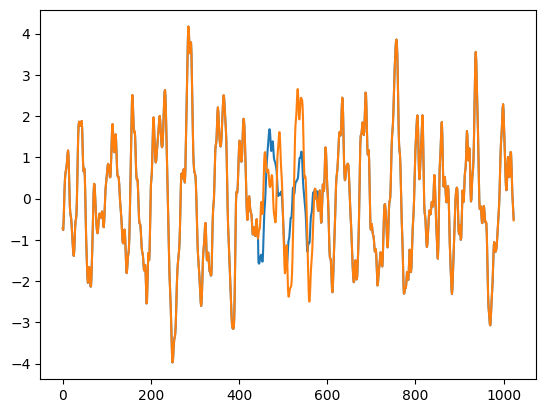

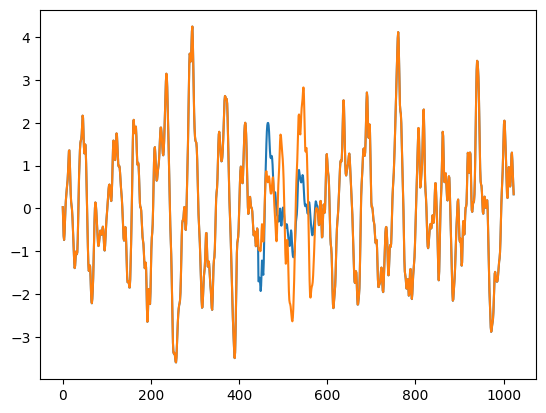

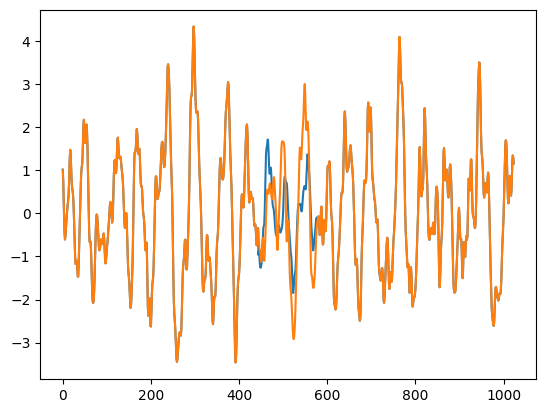

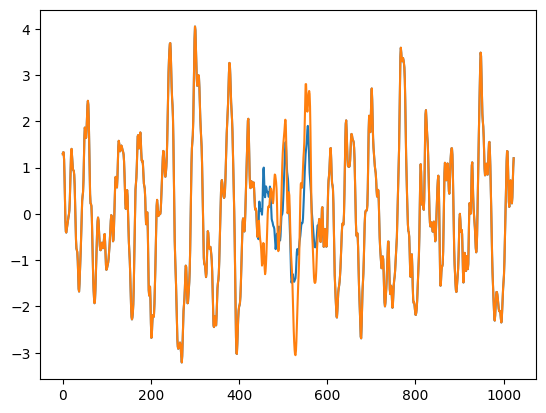

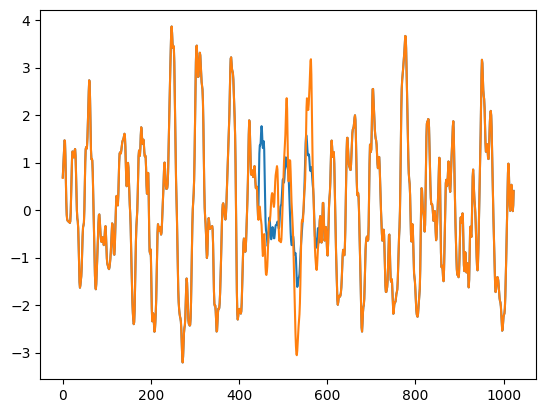

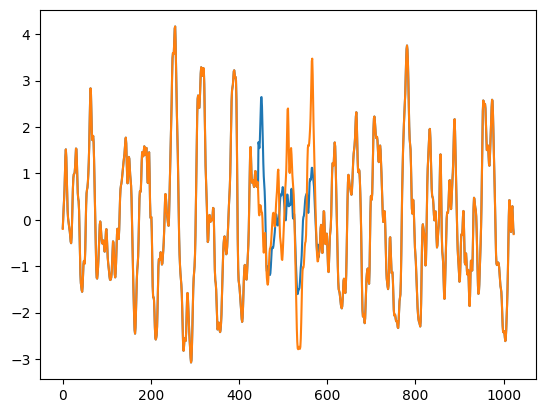

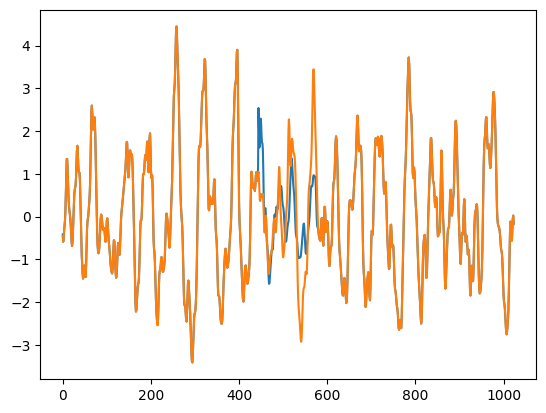

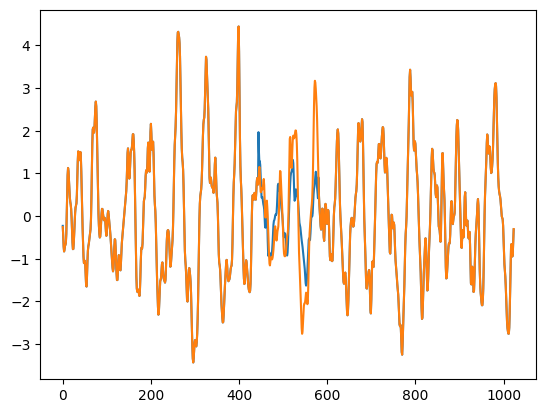

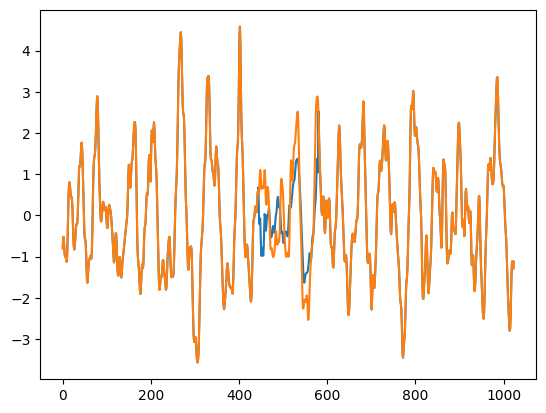

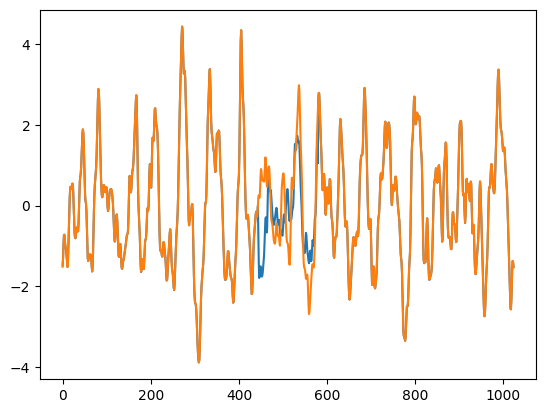

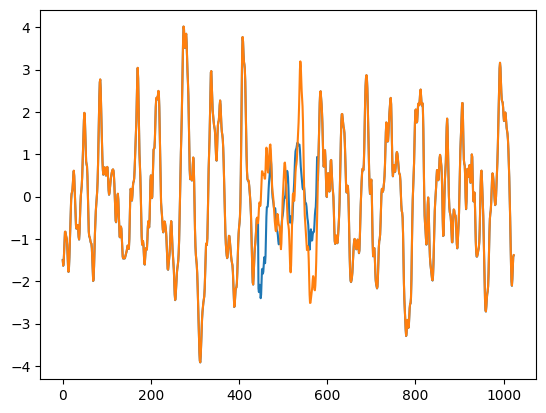

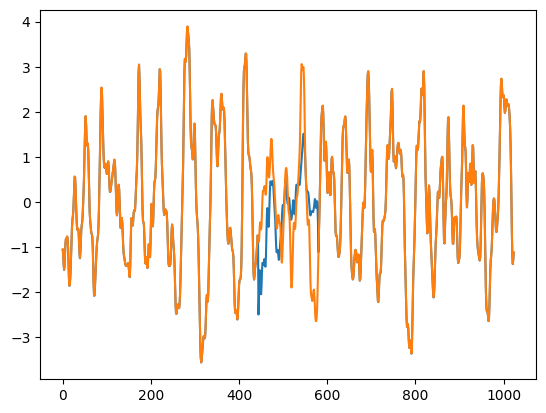

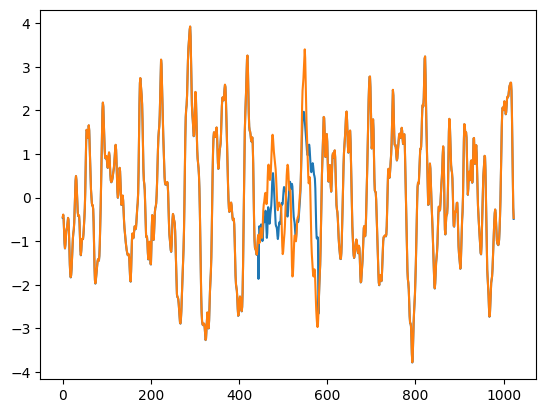

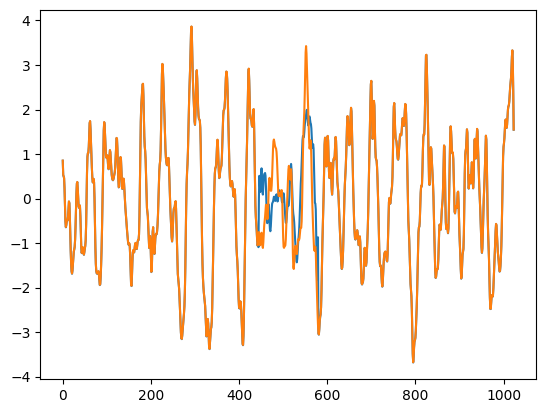

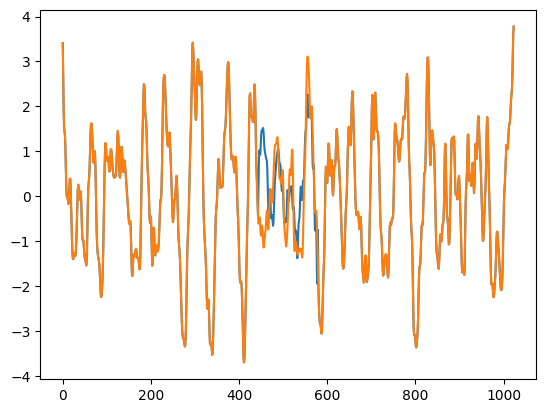

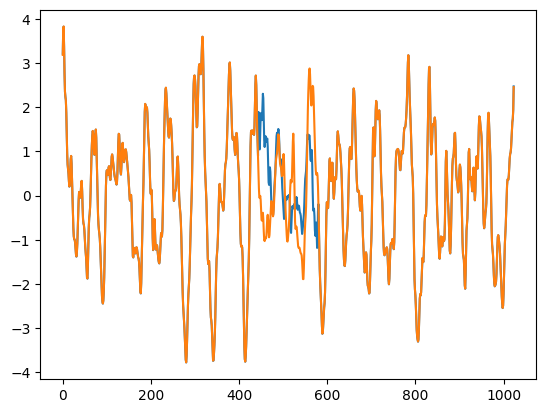

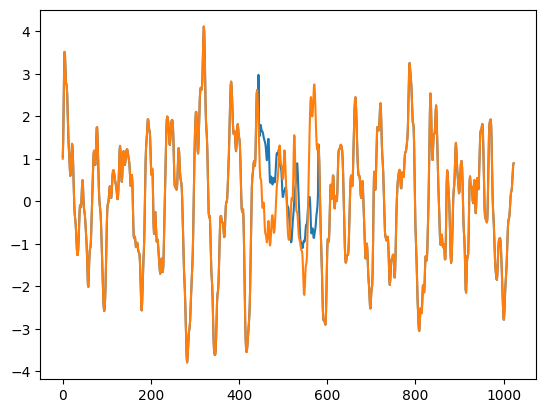

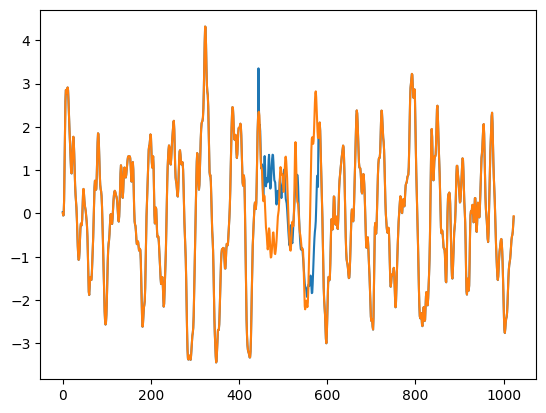

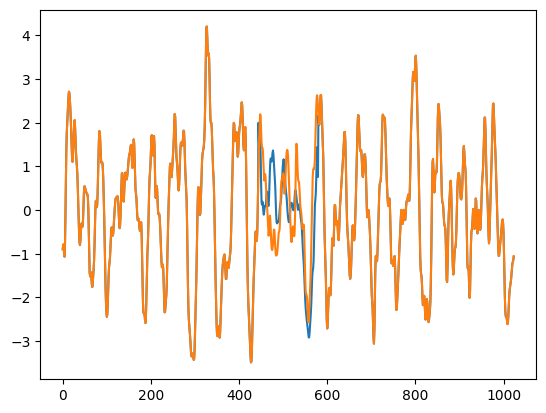

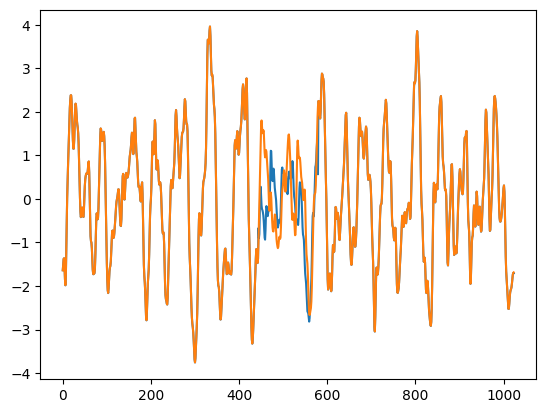

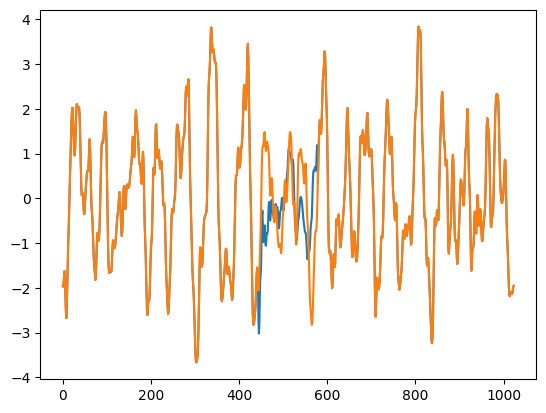

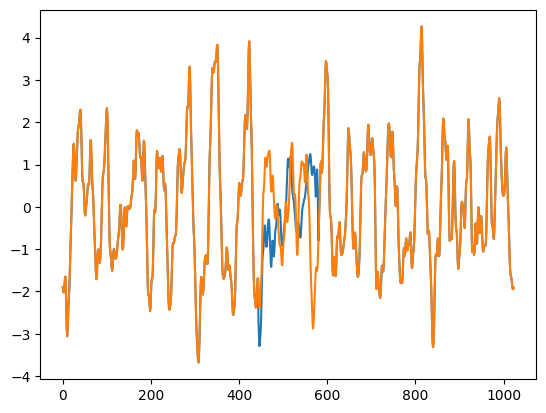

In [ ]:
import jax
import jax.numpy as jnp
from HOSim import solver

eta = irfft2(eta_hat).astype(np.float32)

f_jit = jax.jit(solver.f2d, static_argnums=(2, 3, 4, 5, 6))
rk4_step_jit = solver.rk4_step

eta_hat_0 = jnp.asarray(eta_hat[0])
phi_hat_0 = jnp.zeros_like(eta_hat_0, dtype=jnp.complex64)

y_hat = jnp.stack([eta_hat_0, phi_hat_0])
k0 = 2 * np.pi / length

L1 = np.ones(eta_hat_0.shape[-2:])*1
L1[0, 0] = 0
ky = np.arange(0, modes+1)*k0
kx = np.concatenate((ky, -ky[1:-1][::-1]))
KX, KY = jnp.meshgrid(kx, ky, indexing="ij")
K = np.sqrt(KX**2 + KY**2)
L2 = 1.0 / K - 9.81
L2[0, 0] = 0

y_hat = y_hat.at[0, 31:-31, :].set(0)
y_hat = y_hat.at[1, 31:-31, :].set(0)

sim_10_sec = 10
y_saved = np.zeros((sim_10_sec*20+1, *y_hat.shape), dtype=np.complex64)
y_saved[0] = y_hat

for i in range(sim_10_sec):
    for j in range(1, 401):
        y_hat = rk4_step_jit(200, y_hat, 0.025, modes, 9.81, k0, 4, 0.001, f_jit)
        y_hat = y_hat.at[0, 31:-31, :].set(0)
        y_hat = y_hat.at[1, 31:-31, :].set(0)

        if j % 40 == 0:
            y_old = irfft2(y_hat)
            y_obs = irfft2(y[i*10+j//40, 0])
            y_obs[mask] = irfft2(y_hat[0])[mask]
            y_obs[~mask_2] = irfft2(y_hat[0])[~mask_2]
            y_obs_hat = rfft2(y_obs)
            y_hat = y_hat.at[0].add(1.0 * L1 * (y_obs_hat - y_hat[0]))
            y_hat = y_hat.at[1].add(1.0 * L2 * (y_obs_hat - y_hat[0]))

            plt.plot(irfft2(y_hat[0])[modes, :])
            plt.plot(irfft2(y[i*10+j//40, 0])[modes, :])
            plt.show()

        if j % 20 == 0:
            y_saved[i*20+j//20] = y_hat

#     if i < 6:
#         print("old")
#         y_old = irfft2(y_hat)
#         plt.plot(irfft2(y_hat[0])[modes, :], label="sim")
#         plt.plot(irfft2(y[(i+1)*10, 0])[modes, :], label="Actual")
#         plt.legend()
#         plt.show()

#         y_obs = irfft2(y[(i+1)*10, 0])
#         y_obs[mes_index_1:mes_index_2, mes_index_1:mes_index_2] = irfft2(y_hat[0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2]
#         y_obs_hat = rfft2(y_obs)
#         y_hat = y_hat.at[0].add(0.5 * L1 * (y_obs_hat - y_hat[0]))
#         y_hat = y_hat.at[1].add(0.5 * L2 * (y_obs_hat - y_hat[0]))

#         print("corrected")
#         plt.plot(irfft2(y_hat[0])[modes, :], label="sim")
#         plt.plot(irfft2(y[(i+1)*10, 0])[modes, :], label="Actual")
#         plt.legend()
#         plt.show()

# #     print(f"{i}-done")

# # np.savez_compressed(f'physical_2d_full_{file_index}__.npz', y_saved=y_saved)

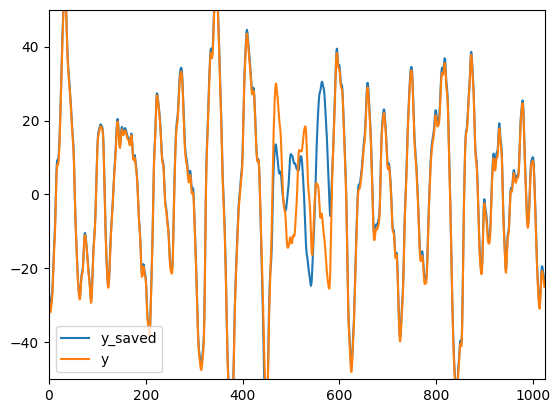

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from numpy.fft import irfft2

fig, ax = plt.subplots()
line1, = ax.plot([], [], label='y_saved')
line2, = ax.plot([], [], label='y')
ax.set_xlim(0, 1024)
ax.set_ylim(-5*10, 5*10)

def update(frame):
    ys1 = irfft2(y_saved[frame*2, 1])[modes, :]
    ys2 = irfft2(y[frame, 1])[modes, :]

    x = np.arange(len(ys1))
    line1.set_data(x, ys1)
    line2.set_data(x, ys2)
    ax.legend(loc=3)
    return line1, line2

ani = FuncAnimation(fig, update, frames=(y_saved.shape[0]-1)//2+1, blit=True)
ani.save("comparison.gif", dpi=80, writer="pillow")
plt.show()

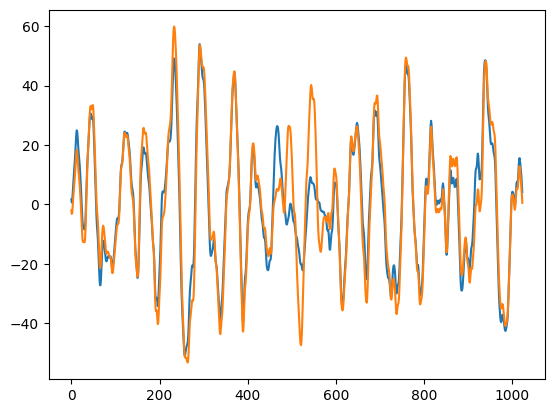

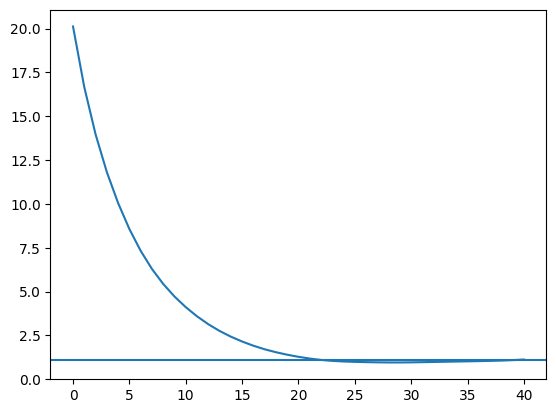

In [92]:
phi_mask = mask_2 & (~mask)

phi_hat_saved = irfft2(y_saved[::2, 1])
phi_hat_actual = irfft2(y[:phi_hat_saved.shape[0], 1])

error = np.mean(np.abs(phi_hat_saved[:, phi_mask] - phi_hat_actual[:, phi_mask]), axis=-1)
plt.plot(phi_hat_saved[10, modes, :])
plt.plot(phi_hat_actual[10, modes, :])
plt.show()

plt.plot(error)
plt.axhline(error[-1])